In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #to get rid of tensorflow CUDA warnings

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Activation, Dense
import h5py

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
train_path = "chairData/"
train_labels = os.listdir(train_path)

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 663 files belonging to 7 classes.
Using 531 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 663 files belonging to 7 classes.
Using 132 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['down', 'left', 'move', 'noobscticle', 'right', 'stop', 'up']


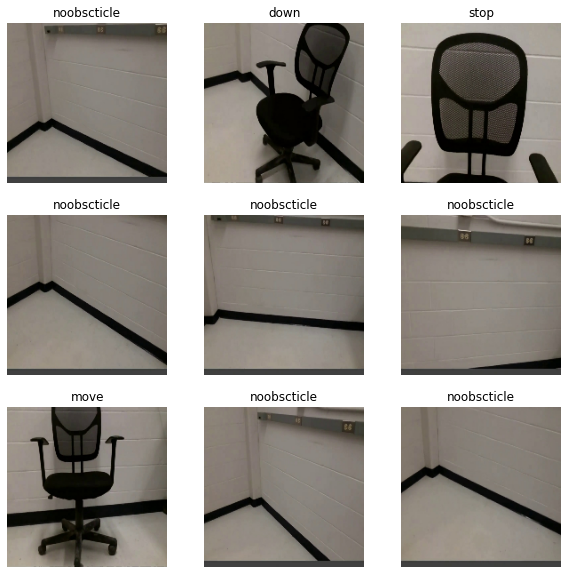

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
17/17 [==============================] - 6s 315ms/step - loss: 1.1667 - accuracy: 0.5687 - val_loss: 0.6106 - val_accuracy: 0.8258
Epoch 2/10
17/17 [==============================] - 5s 310ms/step - loss: 0.4034 - accuracy: 0.8663 - val_loss: 0.4412 - val_accuracy: 0.8485
Epoch 3/10
17/17 [==============================] - 6s 347ms/step - loss: 0.1714 - accuracy: 0.9492 - val_loss: 0.3565 - val_accuracy: 0.8712
Epoch 4/10
17/17 [==============================] - 6s 364ms/step - loss: 0.0898 - accuracy: 0.9774 - val_loss: 0.4782 - val_accuracy: 0.8485
Epoch 5/10
17/17 [==============================] - 6s 330ms/step - loss: 0.0641 - accuracy: 0.9906 - val_loss: 0.2930 - val_accuracy: 0.8939
Epoch 6/10
17/17 [==============================] - 5s 313ms/step - loss: 0.0759 - accuracy: 0.9849 - val_loss: 0.4026 - val_accuracy: 0.8636
Epoch 7/10
17/17 [==============================] - 5s 311ms/step - loss: 0.0296 - accuracy: 0.9925 - val_loss: 0.4170 - val_accuracy: 0.8712
Epoch 

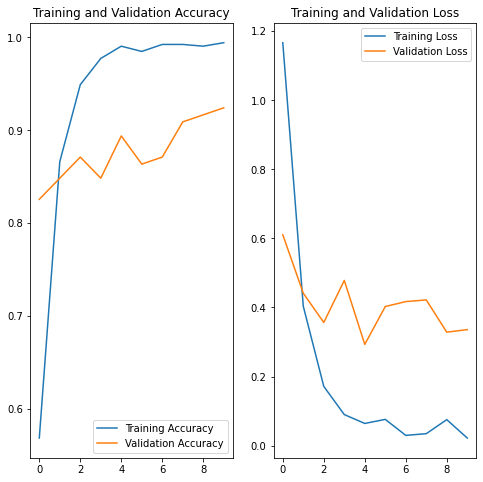

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

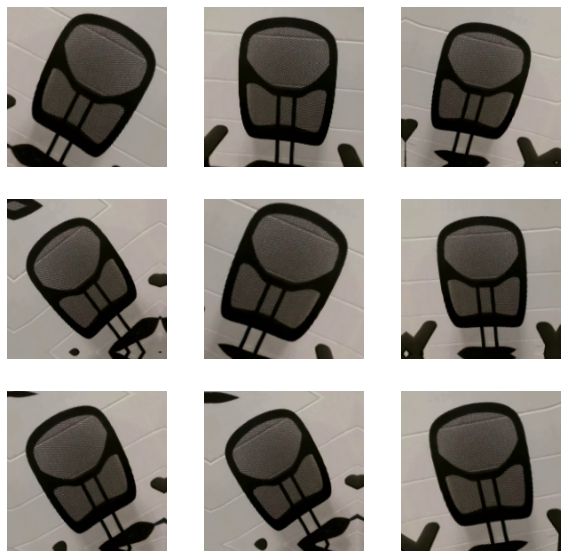

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
#Predict the image

In [21]:
daisy_path = '/home/surendra/ssingh/JypyterNotebook/Code-Base/Deep-learning/chairData//move/frame0.jpg'

img = tf.keras.utils.load_img(
    daisy_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to move with a 96.97 percent confidence.


In [22]:
import pickle

In [23]:
pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://d2ee32fe-2c71-4ebe-a812-b0ef0e543fc8/assets


In [24]:
pickled_model = pickle.load(open('model.pkl', 'rb'))

In [25]:
predictions = pickled_model.predict(img_array)

In [26]:
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to move with a 96.97 percent confidence.
